Alunos:
  - Fabiane Sorbar
  - Vinicius Tessele   

 - Finalize o Colab original para testar todas as instâncias da base de teste. Avalie o desempenhogeralediscuta.
 - Apresente as imagens que foram erroneamente classificadas. Discuta. Apresente as métricasprecision,recall e f1-score por classe.
 - Aumente os hiperparâmetros número de épocas e neurônios por camada para tentar melhorarodesempenho. Discuta. Apresente uma tabela e um gráfico dos resultados.
 - Substituta o otimizador original (sgd) por outros também populares (Adam, RMSprop e Nadam). Compare aperformance em termos da acurácia final e da convergência (gráfico de loss).  


**1 - Importando as bibliotécas e definindo a classe de nomes**

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def relu(z): return np.maximum(0, z)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
class Modelo:
      def __init__(self):
        self.nome = None
        self.model = None
        self.X_train_full = None
        self.y_train_full = None
        self.X_train = None
        self.y_train = None
        self.X_valid = None
        self.y_valid = None
        self.X_test = None
        self.y_test = None
        self.history = None

      def plotarFuncaoAtivacaoReLU(self):
          print('Gerando gráfico da função de ativação ReLU...\n')
          z = np.linspace(-10, 10, 100)
          plt.figure(figsize=(5, 2))
          plt.subplot(1, 3, 3)
          plt.plot(z, relu(z), label='ReLU', color='green')
          plt.title('ReLU')
          plt.grid(True)
          plt.tight_layout()
          plt.show()
          print('Gráfico da função ReLU exibido com sucesso!\n')

      def criarModelo(self, neuroniosPrimeiraCamadaOculta, neuroniosSegundaCamadaOculta):
          print('Montando arquitetura do modelo...\n')
          print(f'- Camada oculta 1: {neuroniosPrimeiraCamadaOculta} neurônios')
          print(f'- Camada oculta 2: {neuroniosSegundaCamadaOculta} neurônios')
          self.model = keras.models.Sequential([
              keras.layers.Input(shape=(28, 28)),
              keras.layers.Flatten(),
              keras.layers.Dense(neuroniosPrimeiraCamadaOculta, activation="relu"),
              keras.layers.Dense(neuroniosSegundaCamadaOculta, activation="relu"),
              keras.layers.Dense(10, activation="softmax")
          ])
          print(self.model.summary())
          print('Modelo criado e pronto para compilação.\n')

      def carregarDataSet(self):
          print('Carregando o Fashion MNIST e separando dados de treino e teste...\n')
          fashion_mnist = keras.datasets.fashion_mnist
          (self.X_train_full, self.y_train_full), (self.X_test, self.y_test) = fashion_mnist.load_data()
          print(f'- Total de exemplos no conjunto de treinamento completo: {len(self.X_train_full)}')
          print('Conjunto de dados carregado com sucesso!\n')

      def separarTreinamentoParaValidacaoCruzada(self):
          print('Separando 5.000 amostras para validação cruzada...\n')
          self.X_valid, self.X_train = self.X_train_full[:5000] / 255.0, self.X_train_full[5000:] / 255.0
          self.y_valid, self.y_train = self.y_train_full[:5000], self.y_train_full[5000:]
          print(f'- Treinamento: {len(self.X_train)} amostras')
          print(f'- Validação: {len(self.y_valid)} amostras')

      def compilarModelo(self, otimizador):
          print('Configurando modelo para o treinamento...\n')
          print(f'- Otimizador selecionado: {otimizador}')
          self.model.compile(
              loss="sparse_categorical_crossentropy",
              optimizer=otimizador,
              metrics=["accuracy"]
          )

      def treinar(self, numEpocas):
          print(f'Iniciando treinamento por {numEpocas} épocas...\nAguarde o processo concluir.\n')
          self.history = self.model.fit(
              self.X_train, self.y_train,
              epochs=numEpocas,
              validation_data=(self.X_valid, self.y_valid)
          )
      def plotarCurvasDeAcuraciaEErro(self):
          print('Exibindo gráfico de desempenho (acurácia e erro)...\n')
          pd.DataFrame(self.history.history).plot(figsize=(8, 5))
          plt.grid(True)
          plt.gca().set_ylim(0, 1)
          plt.show()

      def avaliarConjuntoTestesDesconhecido(self):
          print('Executando avaliação final no conjunto de testes...\n')
          test_loss, test_accuracy = self.model.evaluate(self.X_test / 255.0, self.y_test)
          print(f'Resultado da avaliação:')
          print(f'- Acurácia: {test_accuracy:.4f}')
          print(f'- Erro (loss): {test_loss:.4f}\n')

      def classificar(self, X_novos, y_novos):
          print('Realizando predições e avaliando desempenho do modelo...\n')
          print(f'- Total de amostras a classificar: {len(X_novos)}')
          y_proba = self.model.predict(X_novos)
          classes_y = np.argmax(y_proba, axis=1)
          from sklearn.metrics import classification_report
          relatorio = classification_report(
              y_novos, classes_y, target_names=class_names, digits=4
          )
          print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
          print(relatorio)
          return classes_y

      def classificarMostrandoErros(self, X_novos, y_novos):
          classes_y = self.classificar(X_novos, y_novos)
          print('\nIdentificando erros de classificação...')
          erros_idx = [i for i in range(len(X_novos)) if classes_y[i] != y_novos[i]]
          self.plotarErrosDeClassificacao(y_novos, classes_y, erros_idx)

      def plotarMatrizDeConfusao(self, X_novos, y_novos):
          print(f'Gerando matriz de confusão {self.nome}...\n')
          y_proba = self.model.predict(X_novos)
          y_pred = np.argmax(y_proba, axis=1)

          matriz_confusao = confusion_matrix(y_novos, y_pred)

          plt.figure(figsize=(10, 8))
          sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues',
                      xticklabels=class_names, yticklabels=class_names)
          plt.xlabel('Classe Predita')
          plt.ylabel('Classe Verdadeira')
          plt.title(f'Matriz de Confusão {self.nome}')
          plt.tight_layout()
          plt.show()

**2 - Processamento e treinamento com 30 épocas modelo sgd (Stochastic Gradient Descent)**

Gerando gráfico da função de ativação ReLU...



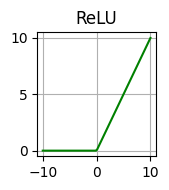

Gráfico da função ReLU exibido com sucesso!

Montando arquitetura do modelo...

- Camada oculta 1: 300 neurônios
- Camada oculta 2: 100 neurônios


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo criado e pronto para compilação.

Carregando o Fashion MNIST e separando dados de treino e teste...

- Total de exemplos no conjunto de treinamento completo: 60000
Conjunto de dados carregado com sucesso!

Separando 5.000 amostras para validação cruzada...

- Treinamento: 55000 amostras
- Validação: 5000 amostras
Configurando modelo para o treinamento...

- Otimizador selecionado: sgd
Iniciando treinamento por 30 épocas...
Aguarde o processo concluir.

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6712 - loss: 1.0261 - val_accuracy: 0.8292 - val_loss: 0.5055
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8234 - loss: 0.5102 - val_accuracy: 0.8356 - val_loss: 0.4946
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8413 - loss: 0.4522 - val_accuracy: 0.8506 - val_loss: 0.4339
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8502 - loss: 0.4268 - val_accuracy: 0.8676 - val_loss: 0.3925
Epoch 5/30

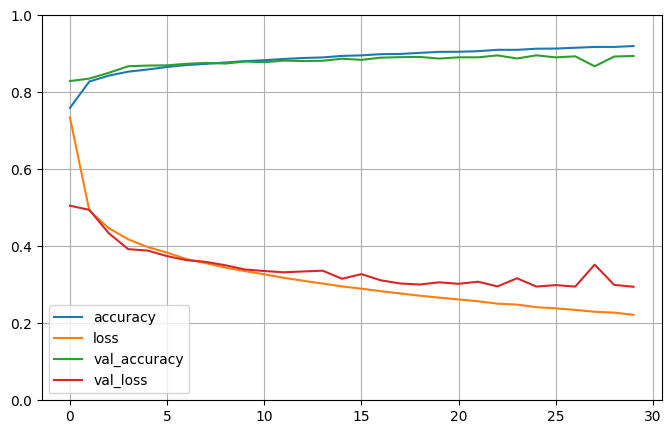

Executando avaliação final no conjunto de testes...

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8843 - loss: 0.3288
Resultado da avaliação:
- Acurácia: 0.8845
- Erro (loss): 0.3241

Gerando matriz de confusão Modelo_sgd 30 épocas 300 primeira camada e 100 segunda camada...

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


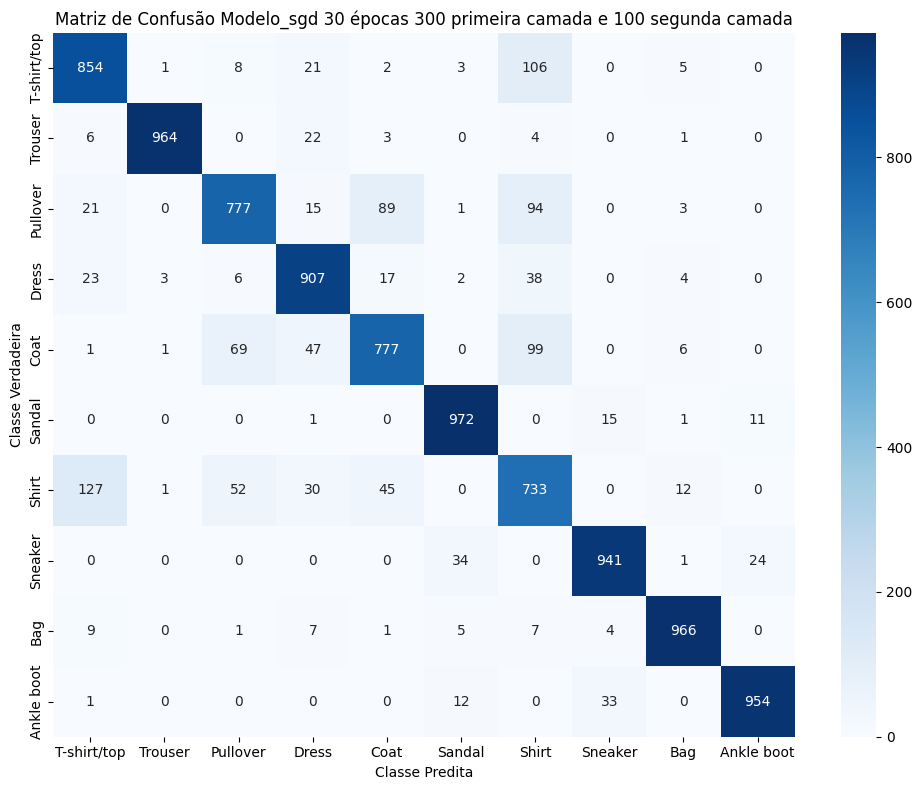

In [ ]:
modelo = Modelo()
modelo.plotarFuncaoAtivacaoReLU()
modelo.criarModelo(300, 100) #300 primeira camada oculta e 100 na segunda camada oculta
modelo.carregarDataSet()
modelo.separarTreinamentoParaValidacaoCruzada()
modelo.compilarModelo("sgd") #otimizador
modelo.treinar(30) #30 épocas
modelo.plotarCurvasDeAcuraciaEErro()
modelo.avaliarConjuntoTestesDesconhecido()

X_novos = modelo.X_test
y_novos = modelo.y_test
modelo.nome = "Modelo_sgd 30 épocas 300 primeira camada e 100 segunda camada"
modelo.plotarMatrizDeConfusao(modelo.X_test / 255.0, modelo.y_test)

**3 - Ajuste dos hiperparâmetros: número de épocas e neurônios por camada.**

Montando arquitetura do modelo...

- Camada oculta 1: 400 neurônios
- Camada oculta 2: 200 neurônios


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 400)            │       314,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 396,210 (1.51 MB)

 Trainable params: 396,210 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo criado e pronto para compilação.

Configurando modelo para o treinamento...

- Otimizador selecionado: sgd
Iniciando treinamento por 40 épocas...
Aguarde o processo concluir.

Epoch 1/40
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6950 - loss: 0.9548 - val_accuracy: 0.8378 - val_loss: 0.4892
Epoch 2/40
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8277 - loss: 0.4919 - val_accuracy: 0.8376 - val_loss: 0.4526
Epoch 3/40
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8469 - loss: 0.4406 - val_accuracy: 0.8550 - val_loss: 0.4291
Epoch 4/40
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8546 - loss: 0.4160 - val_accuracy: 0.8666 - val_loss: 0.3982
Epoch 5/40
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8630 - loss: 0.3910 - val_accuracy: 0.8582 - val_loss: 0.4016
Epoch 6/40
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8692 - loss: 0.3695 - val_accuracy: 0.8734 - val_loss: 0.3757
Epoch 7/40
1719/1719 ━━━━━━━━━━

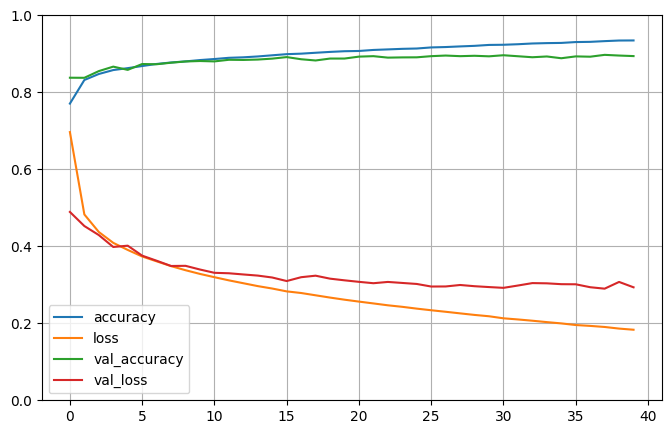

Executando avaliação final no conjunto de testes...

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8884 - loss: 0.3228
Resultado da avaliação:
- Acurácia: 0.8876
- Erro (loss): 0.3242

Gerando matriz de confusão Modelo_sgd 40 épocas 400 primeira camada e 200 segunda camada...

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


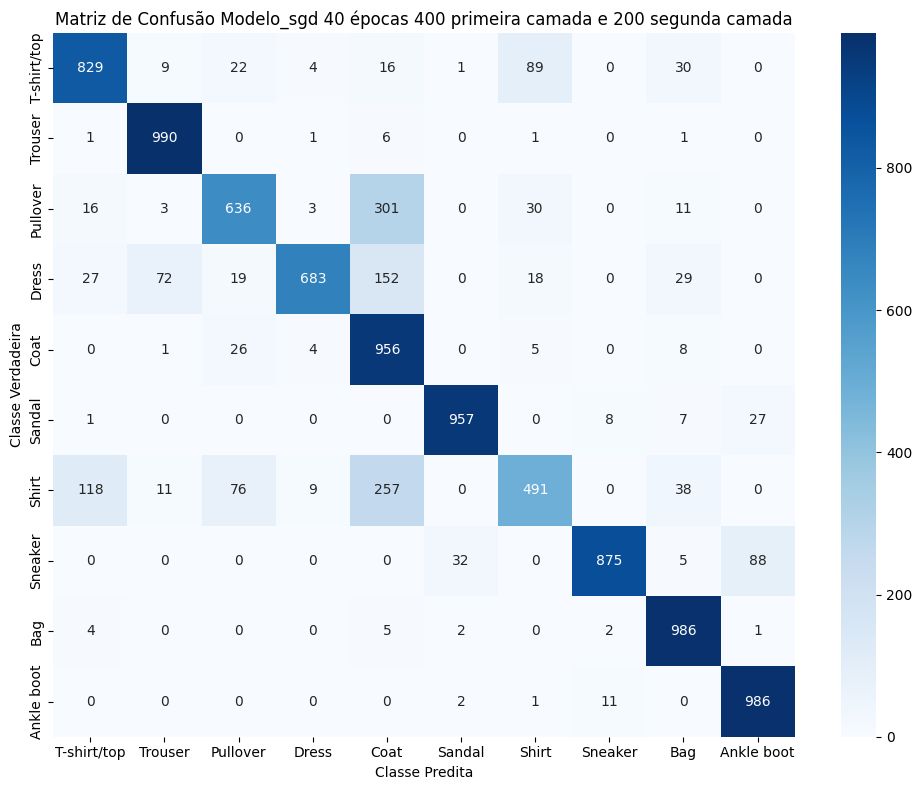

In [ ]:
modelo.criarModelo(400, 200) #400 neuronios na primeira camada oculta e 200 na segunda oculta
modelo.compilarModelo("sgd") #otimizador
modelo.treinar(40) #40 épocas
modelo.plotarCurvasDeAcuraciaEErro()
modelo.avaliarConjuntoTestesDesconhecido()
modelo.nome = "Modelo_sgd 40 épocas 400 primeira camada e 200 segunda camada"
modelo.plotarMatrizDeConfusao(X_novos, y_novos)


**A análise do sgd com 30 épocas 300-100 camadas x 40 épocas 400-200: o primeiro modelo se mostrou mais eficiente classificando melhor as imagens que são semelhentes.**

4- Substitutindo o otimizador original (sgd) por outros (Adam, RMSprop e Nadam) e comparando a performance[texto do link](https://).

Montando arquitetura do modelo...

- Camada oculta 1: 300 neurônios
- Camada oculta 2: 100 neurônios


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo criado e pronto para compilação.

Configurando modelo para o treinamento...

- Otimizador selecionado: adam
Iniciando treinamento por 30 épocas...
Aguarde o processo concluir.

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7830 - loss: 0.6128 - val_accuracy: 0.8498 - val_loss: 0.3938
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8640 - loss: 0.3712 - val_accuracy: 0.8634 - val_loss: 0.3730
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8793 - loss: 0.3300 - val_accuracy: 0.8910 - val_loss: 0.3100
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8898 - loss: 0.3005 - val_accuracy: 0.8794 - val_loss: 0.3322
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8935 - loss: 0.2873 - val_accuracy: 0.8906 - val_loss: 0.3047
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8992 - loss: 0.2667 - val_accuracy: 0.8808 - val_loss: 0.3276
Epoch 7/30
1719/1719 ━━━━━━━━

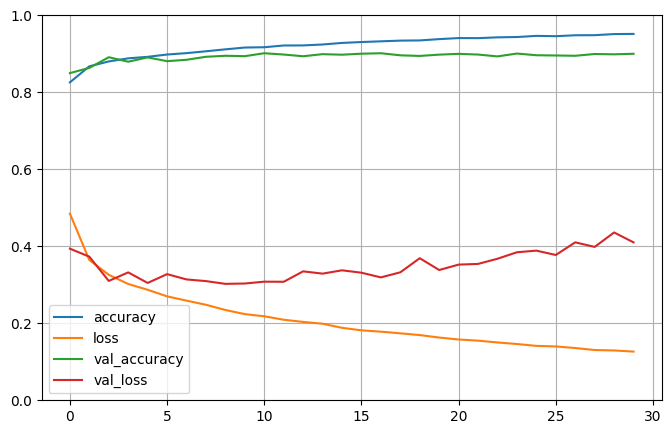

Executando avaliação final no conjunto de testes...

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8927 - loss: 0.4445
Resultado da avaliação:
- Acurácia: 0.8919
- Erro (loss): 0.4625

Gerando matriz de confusão Modelo_adam 30 épocas 300 primeira camada e 100 segunda camada...

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


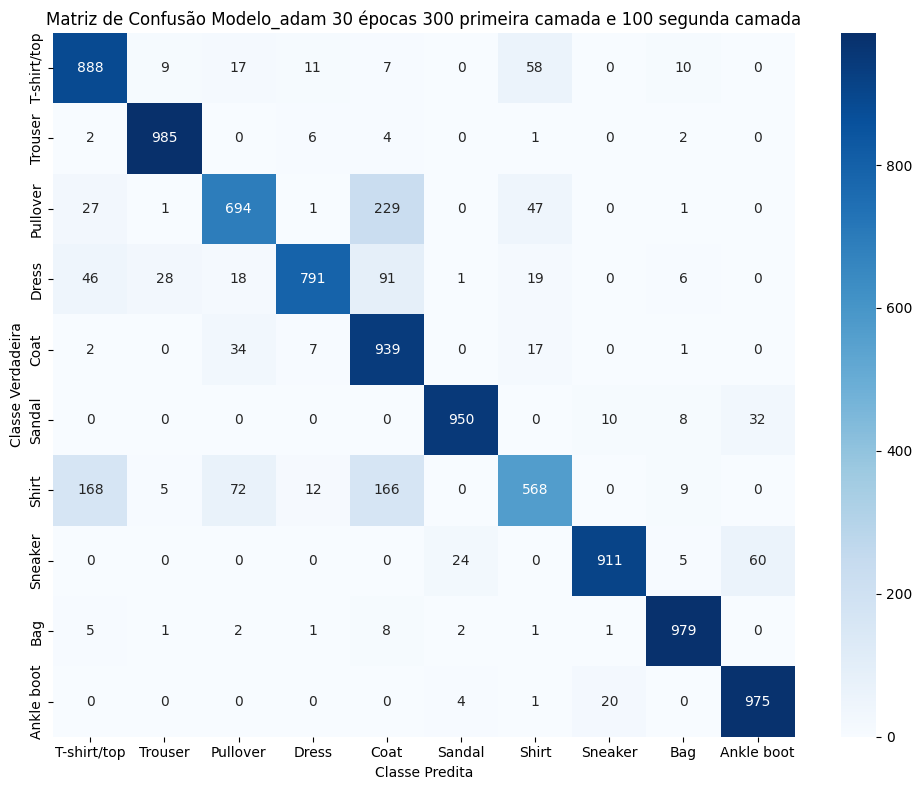

Configurando modelo para o treinamento...

- Otimizador selecionado: rmsprop
Iniciando treinamento por 30 épocas...
Aguarde o processo concluir.

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9556 - loss: 0.1158 - val_accuracy: 0.9016 - val_loss: 0.5420
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9546 - loss: 0.1194 - val_accuracy: 0.8952 - val_loss: 0.6221
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9544 - loss: 0.1220 - val_accuracy: 0.8932 - val_loss: 0.6233
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9533 - loss: 0.1319 - val_accuracy: 0.8978 - val_loss: 0.6432
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9518 - loss: 0.1334 - val_accuracy: 0.8990 - val_loss: 0.6540
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9534 - loss: 0.1364 - val_accuracy: 0.8914 - val_loss: 0.6656
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9516

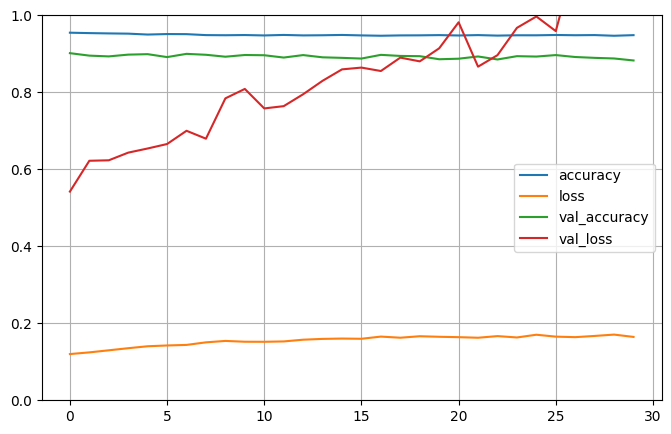

Executando avaliação final no conjunto de testes...

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8785 - loss: 1.2074
Resultado da avaliação:
- Acurácia: 0.8792
- Erro (loss): 1.2332

Gerando matriz de confusão Modelo_rmsprop 30 épocas 200 primeira camada e 100 segunda camada...

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


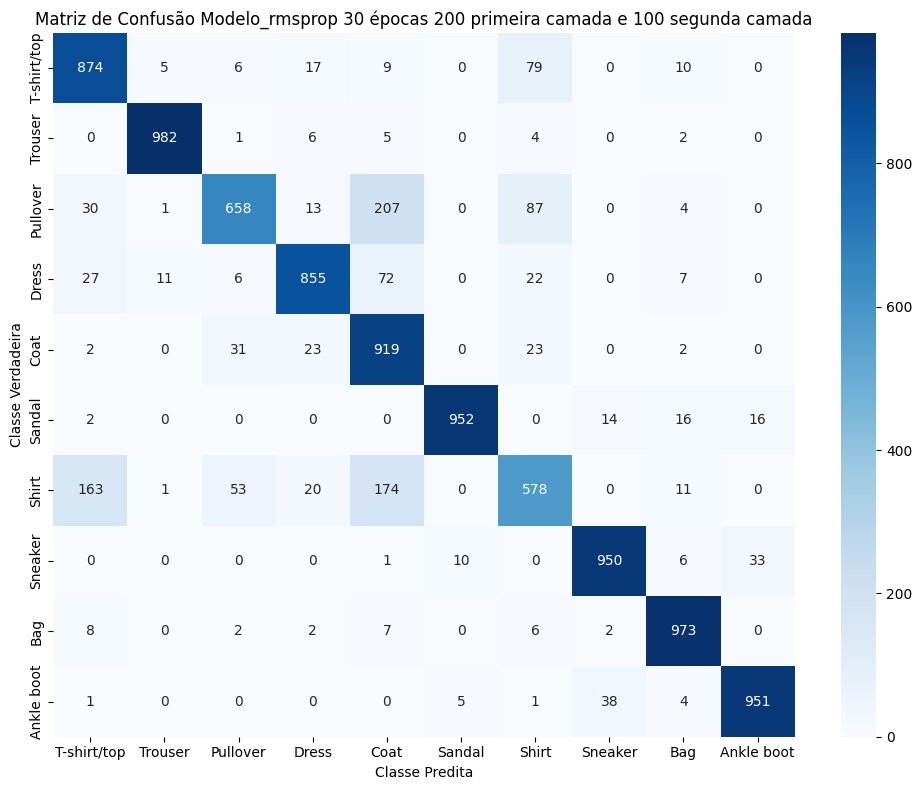

Configurando modelo para o treinamento...

- Otimizador selecionado: nadam
Iniciando treinamento por 30 épocas...
Aguarde o processo concluir.

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9418 - loss: 0.1994 - val_accuracy: 0.8924 - val_loss: 0.8477
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9427 - loss: 0.1800 - val_accuracy: 0.8950 - val_loss: 0.7794
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9463 - loss: 0.1633 - val_accuracy: 0.8962 - val_loss: 0.6881
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9458 - loss: 0.1624 - val_accuracy: 0.8940 - val_loss: 0.6705
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9496 - loss: 0.1465 - val_accuracy: 0.8930 - val_loss: 0.6602
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9504 - loss: 0.1416 - val_accuracy: 0.8980 - val_loss: 0.7087
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.95

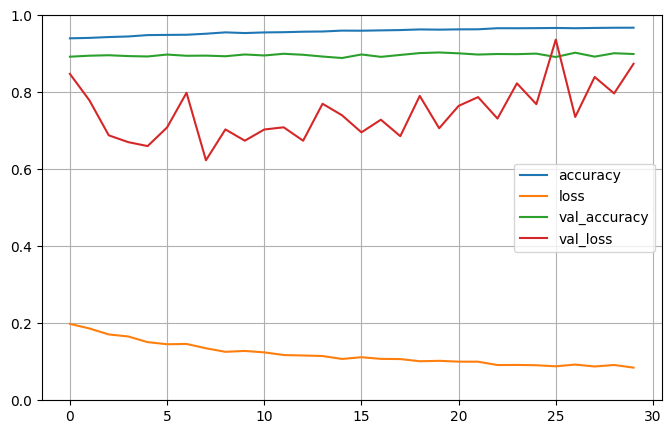

Executando avaliação final no conjunto de testes...

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8827 - loss: 0.8976
Resultado da avaliação:
- Acurácia: 0.8835
- Erro (loss): 0.9128

Gerando matriz de confusão Modelo_nadam 30 épocas 200 primeira camada e 100 segunda camada...

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


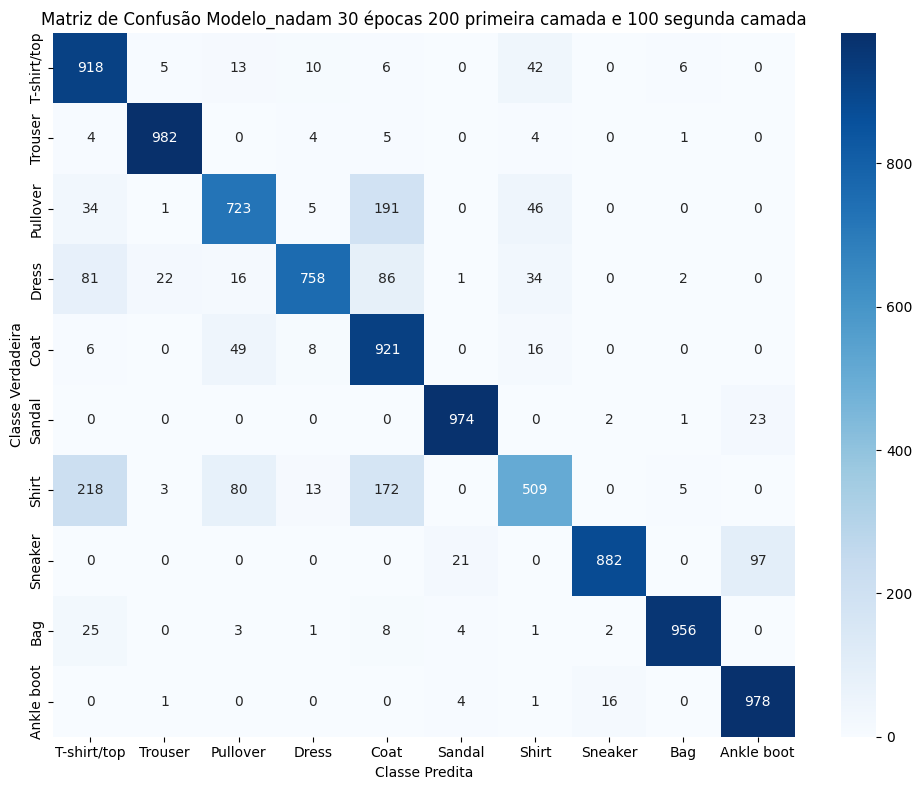

In [ ]:
modelo.criarModelo(300, 100) #300 primeira camada oculta e 100 na segunda camada oculta
modelo.compilarModelo("adam") #otimizador
modelo.treinar(30) #30 épocas
modelo.plotarCurvasDeAcuraciaEErro()
modelo.avaliarConjuntoTestesDesconhecido()
modelo.nome = "Modelo_adam 30 épocas 300 primeira camada e 100 segunda camada"
modelo.plotarMatrizDeConfusao(X_novos, y_novos)

modelo.compilarModelo("rmsprop") #otimizador
modelo.treinar(30) #30 épocas
modelo.plotarCurvasDeAcuraciaEErro()
modelo.avaliarConjuntoTestesDesconhecido()
modelo.nome = "Modelo_rmsprop 30 épocas 300 primeira camada e 100 segunda camada"
modelo.plotarMatrizDeConfusao(X_novos, y_novos)

modelo.compilarModelo("nadam") #otimizador
modelo.treinar(30) #30 épocas
modelo.plotarCurvasDeAcuraciaEErro()
modelo.avaliarConjuntoTestesDesconhecido()
modelo.nome = "Modelo_nadam 30 épocas 300 primeira camada e 100 segunda camada"
modelo.plotarMatrizDeConfusao(X_novos, y_novos)

Conclusão
Nadam: 3 categorias (Camiseta, Sandália, Bota)
Adam: 3 categorias (Calça, Casaco, Bolsa)
SGD: 3 categorias (Pullover, Vestido, Camisa)
RMSprop: 1 categoria (Tênis)
Importante destacar o SGD tem um bom desempenho em categorias que possuem classes similares.

| Classe | SGD | Adam | RMSprop | Nadam | Melhor |
|--------|-----|------|---------|-------|---------|
| **Camiseta** | 854 | 888 | 874 | **918** | Nadam |
| **Calça** | 964 | **985** | 982 | 982 | Adam |
| **Pullover** | **777** | 694 | 658 | 723 | SGD |
| **Vestido** | **907** | 791 | 855 | 758 | SGD |
| **Casaco** | 777 | **939** | 919 | 921 | Adam |
| **Sandália** | 972 | 950 | 952 | **974** | Nadam |
| **Camisa** | **733** | 568 | 578 | 509 | SGD |
| **Tênis** | 941 | 911 | **950** | 882 | RMSprop |
| **Bolsa** | 966 | **979** | 973 | 956 | Adam |
| **Bota** | 954 | 975 | 951 | **978** | Nadam |


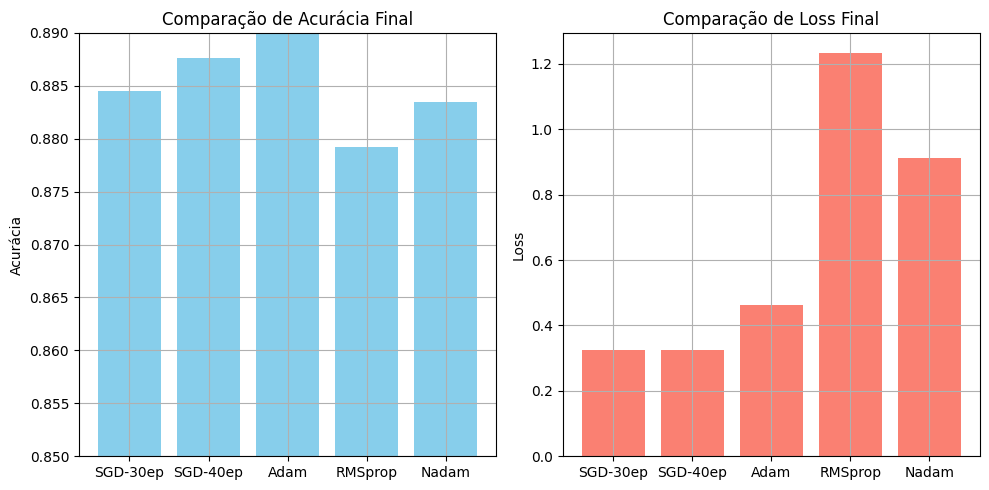

In [ ]:
import matplotlib.pyplot as plt

experimentos = ["SGD-30ep", "SGD-40ep", "Adam", "RMSprop", "Nadam"]
acuracias = [0.8845, 0.8876, 0.8919, 0.8792, 0.8835]
losses = [0.3241, 0.3242, 0.4625, 1.2332, 0.9128]

plt.figure(figsize=(10, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.bar(experimentos, acuracias, color='skyblue')
plt.ylim(0.85, 0.89)
plt.title('Comparação de Acurácia Final')
plt.ylabel('Acurácia')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.bar(experimentos, losses, color='salmon')
plt.title('Comparação de Loss Final')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()
